In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dataclasses import dataclass
from dataclasses import field
from pathlib import Path
from statistics import mean
from typing import List

In [2]:
@dataclass
class ResultItem:
    dataset_name: str
    num_mix_components: int
    mae_loss: bool
    cold_starts: bool
    regularization: float
    max_epochs: int
    patience: int
    seed: int
    # Results for all iterations
    trained_processtime: List[float] = field(default_factory=list)
    trained_epochs: List[float] = field(default_factory=list)
    final_loss_val: List[float] = field(default_factory=list)
    final_loss_test: List[float] = field(default_factory=list)
    final_time_nll_test: List[float] = field(default_factory=list)
    final_mark_nll_test: List[float] = field(default_factory=list)
    final_acc_test: List[float] = field(default_factory=list)
    correct_predicted_marks: list = field(default_factory=list)
    final_mae_test: List[float] = field(default_factory=list)
    inter_time_errors: list = field(default_factory=list)

    def loss_val_mean(self) -> float:
        return mean(self.final_loss_val)
    
@dataclass
class Observation:
    app_name: str
    cold_starts: bool
    value: float

In [3]:
# Avg process time and epochs for training 

# Configuration
#measure = "trained_processtime"
measure = "trained_epochs"

def app_name(filename: str) -> str:
    app_name = filename[filename.rfind(":")+4:filename.find("_fetched_")]
    if "_rand_" in filename:
        app_name += "_rand"
    return app_name

def is_cs_dataset(filename: str) -> bool:
    return "_b_" in filename

def get_item(items: list[ResultItem], mae_loss: bool, cold_starts: bool, feature: bool) -> ResultItem:
    for item in items:
        if item.mae_loss == mae_loss and is_cs_dataset(item.dataset_name) == cold_starts and item.cold_starts == feature:
            return item
    raise Exception("No item found.")

# Merge low and high load items in dictionary.
app_items = {}
for results_dir in ["final_low_load_n_1000", "final_high_load_n_1000"]:
    paths = Path(f"train_results/{results_dir}").glob('*.pkl')
    for path in paths:
        with open(path, "rb") as stream:
            result_items = pickle.load(stream)
        app = app_name(str(path))
        for item in result_items:
            if app in app_items:
                app_items[app].append(item)
            else:
                app_items[app] = []
                app_items[app].append(item)
                
# Print row strings
unit = ""
if measure == "trained_processtime":
    unit = "s"
chars = '\_'
for app in ["sequence", "parallel_small", "tree_small", "fanout_small", "parallel_large", 
            "tree_large", "fanout_large", "sequence_rand", "parallel_small_rand", "tree_small_rand",
            "fanout_small_rand", "parallel_large_rand", "tree_large_rand", "fanout_large_rand"]:
    items = app_items[app]
    print(f"{app.replace('_', chars):22s} " 
          f"& {int(np.mean(getattr(get_item(items, mae_loss=False, cold_starts=False, feature=False), measure)))}{unit} " 
          f"& {int(np.mean(getattr(get_item(items, mae_loss=False, cold_starts=True, feature=False), measure)))}{unit} "  
          f"& {int(np.mean(getattr(get_item(items, mae_loss=False, cold_starts=True, feature=True), measure)))}{unit} "  
          f"& {int(np.mean(getattr(get_item(items, mae_loss=True, cold_starts=False, feature=False), measure)))}{unit} "  
          f"& {int(np.mean(getattr(get_item(items, mae_loss=True, cold_starts=True, feature=False), measure)))}{unit} "  
          f"& {int(np.mean(getattr(get_item(items, mae_loss=True, cold_starts=True, feature=True), measure)))}{unit} \\\\ \\hline")

sequence               & 372 & 201 & 249 & 1951 & 4000 & 4000 \\ \hline
parallel\_small        & 674 & 404 & 288 & 3483 & 4000 & 4000 \\ \hline
tree\_small            & 297 & 461 & 285 & 1943 & 3983 & 4000 \\ \hline
fanout\_small          & 194 & 209 & 207 & 2092 & 4000 & 4000 \\ \hline
parallel\_large        & 710 & 478 & 315 & 2587 & 3984 & 4000 \\ \hline
tree\_large            & 230 & 499 & 416 & 1444 & 3348 & 3321 \\ \hline
fanout\_large          & 330 & 364 & 252 & 1839 & 3798 & 4000 \\ \hline
sequence\_rand         & 322 & 413 & 225 & 1730 & 4000 & 4000 \\ \hline
parallel\_small\_rand  & 235 & 278 & 252 & 1463 & 4000 & 4000 \\ \hline
tree\_small\_rand      & 345 & 458 & 292 & 1161 & 4000 & 4000 \\ \hline
fanout\_small\_rand    & 642 & 461 & 249 & 1919 & 3907 & 4000 \\ \hline
parallel\_large\_rand  & 201 & 199 & 182 & 900 & 3824 & 4000 \\ \hline
tree\_large\_rand      & 249 & 402 & 376 & 967 & 3115 & 3694 \\ \hline
fanout\_large\_rand    & 514 & 448 & 283 & 2148 & 3903 & 4000 \\ \

In [4]:
# Labels for y-axis ticks
space1 = 8
space2 = 5
space3 = 10

nonrand_small_str = f"{'Non-rand':{space1}} {'small':{space2}}"
nonrand_large_str = f"{'Non-rand':{space1}} {'large':{space2}}"
rand_small_str = f"{'Rand':{space3}} {'small':{space2}}"
rand_large_str = f"{'Rand':{space3}} {'large':{space2}}"

y_label_map = {
    "sequence":            f"{nonrand_small_str} sequence",
    "parallel_small":      f"{nonrand_small_str} parallel",
    "tree_small":          f"{nonrand_small_str} tree",
    "fanout_small":        f"{nonrand_small_str} fanout", 
    "parallel_large":      f"{nonrand_large_str} parallel",
    "tree_large":          f"{nonrand_large_str} tree",
    "fanout_large":        f"{nonrand_large_str} fanout",
    "sequence_rand":       f"{rand_small_str} sequence",
    "parallel_small_rand": f"{rand_small_str} parallel",
    "tree_small_rand":     f"{rand_small_str} tree",
    "fanout_small_rand":   f"{rand_small_str} fanout",
    "parallel_large_rand": f"{rand_large_str} parallel",
    "tree_large_rand":     f"{rand_large_str} tree",
    "fanout_large_rand":   f"{rand_large_str} fanout"
}

In [5]:
def file_to_plot(filename: str) -> bool:
    for app in apps:
        if app in filename:
            return True
    return False

def app_name(filename: str) -> str:
    app_name = filename[filename.rfind(":")+4:filename.find("_fetched_")]
    if "_rand_" in filename:
        app_name += "_rand"
    #return app_name
    return y_label_map[app_name]

def resultitem_to_plot(item: ResultItem, measure: str, cold_starts: bool) -> bool:
    if item.cold_starts == cold_starts or item.cold_starts == False:
        if measure in ["final_loss_test", "final_acc_test", "final_time_nll_test", "final_mark_nll_test"]:
            return item.mae_loss == False
        elif measure in ["final_mae_test", "inter_time_errors"]:
            return item.mae_loss == True
    return False

def observations_from_resultitem(item: ResultItem, measure: str, app_name: str) -> list[Observation]:
    observations = []
    vals = getattr(item, measure)
    if measure == "inter_time_errors":
        # Flat the list of 2d numpy arrays.
        vals = [item for sublist in vals for item in sublist.reshape(-1)]
    for val in vals:
        observations.append(Observation(app_name=app_name, cold_starts=item.cold_starts, value=val))
    return observations

def observations_from_apps(apps: list[str], results_dir: str, measure: str, cold_starts: bool) -> pd.DataFrame:
    # Extract observations from matching files.
    observations = []
    paths = Path(f"train_results/{results_dir}").glob('*.pkl')
    for path in paths:
        if file_to_plot(str(path)):
            with open(path, "rb") as stream:
                result_items = pickle.load(stream)
            result_items = list(filter(lambda item: resultitem_to_plot(item, measure, cold_starts), result_items))
            app = app_name(str(path))
            for item in result_items:
                observations += observations_from_resultitem(item, measure, app)          
    return pd.DataFrame(observations)

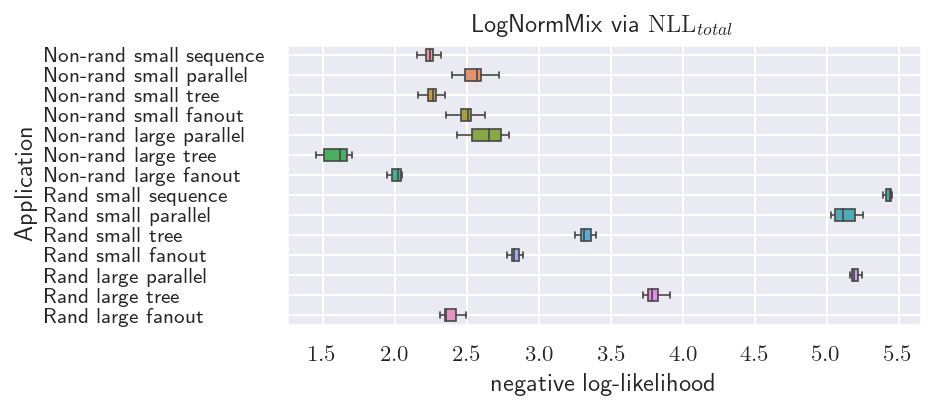

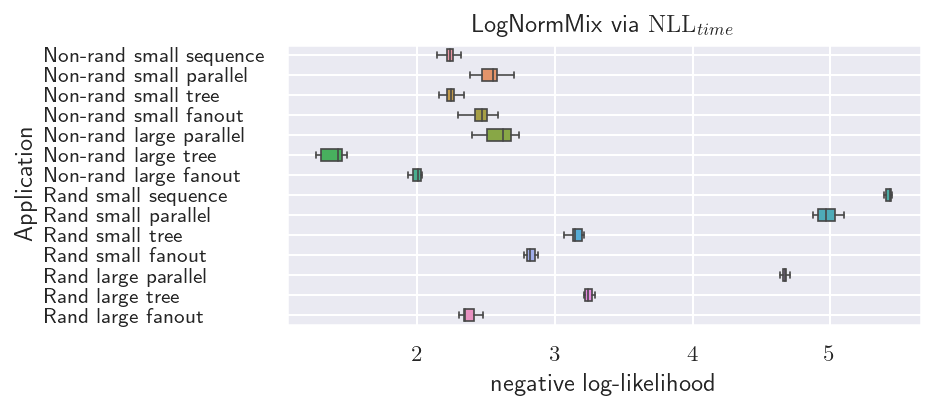

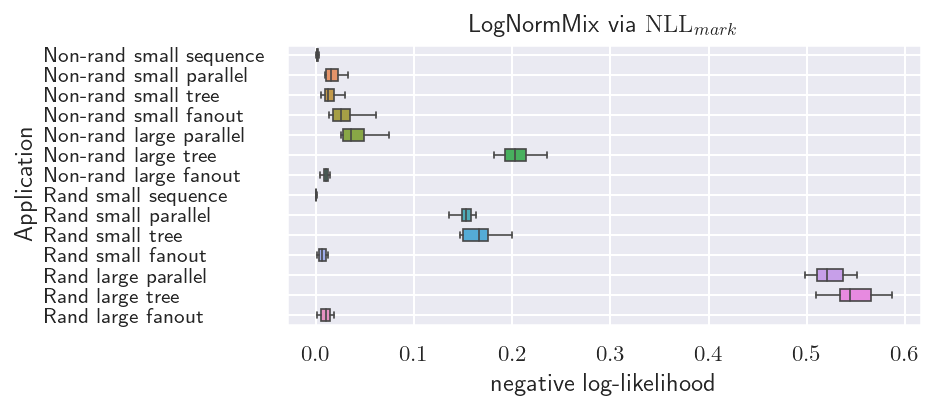

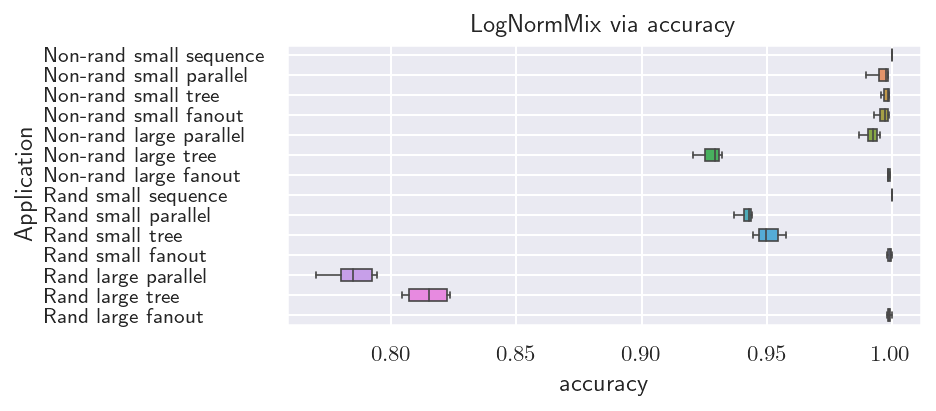

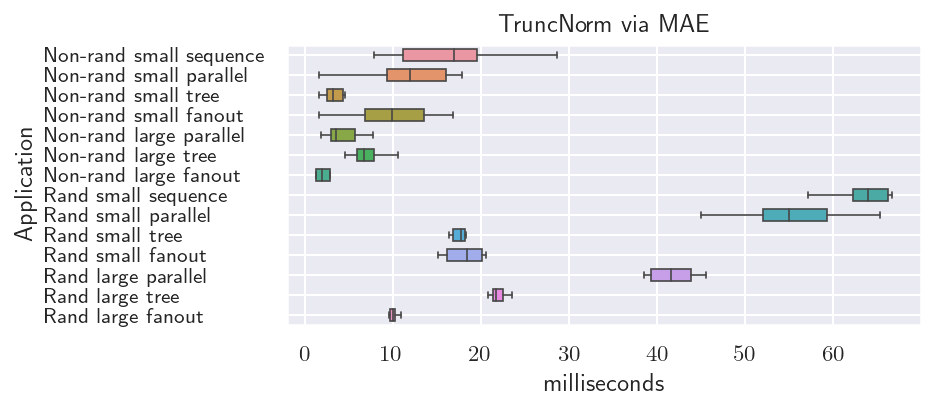

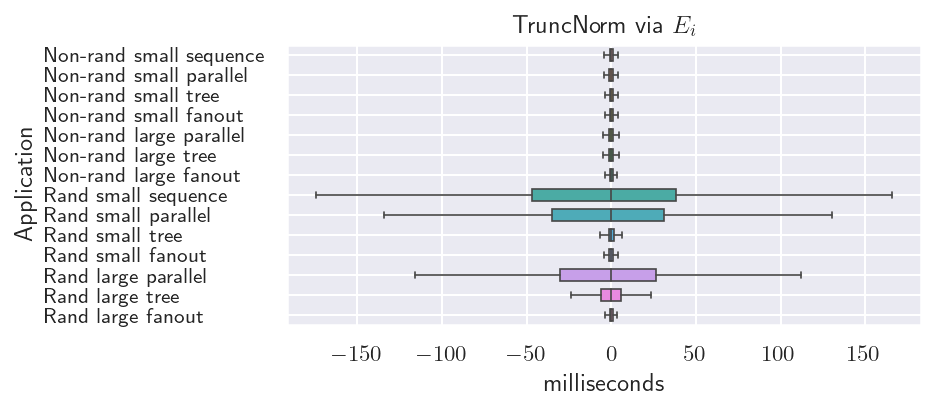

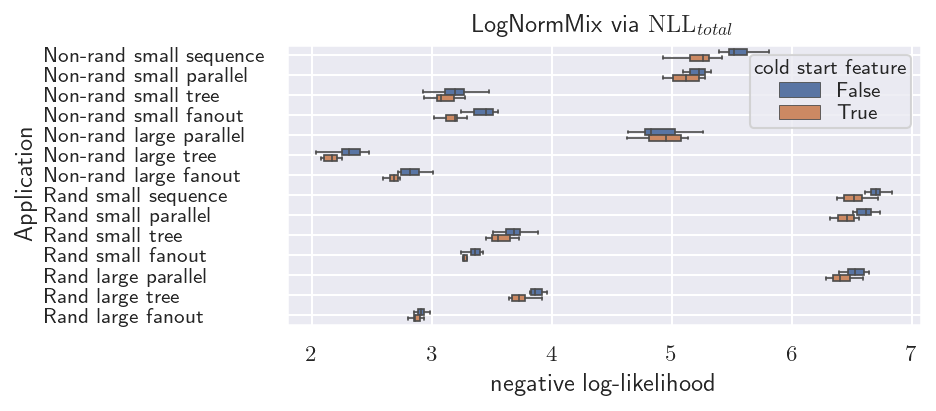

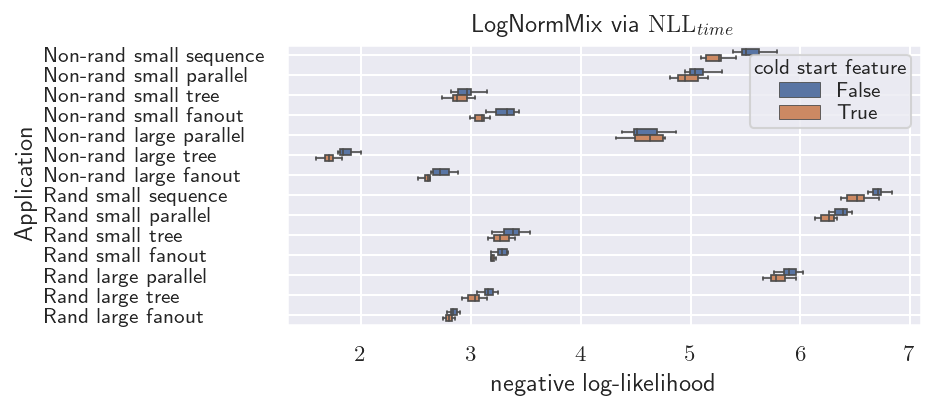

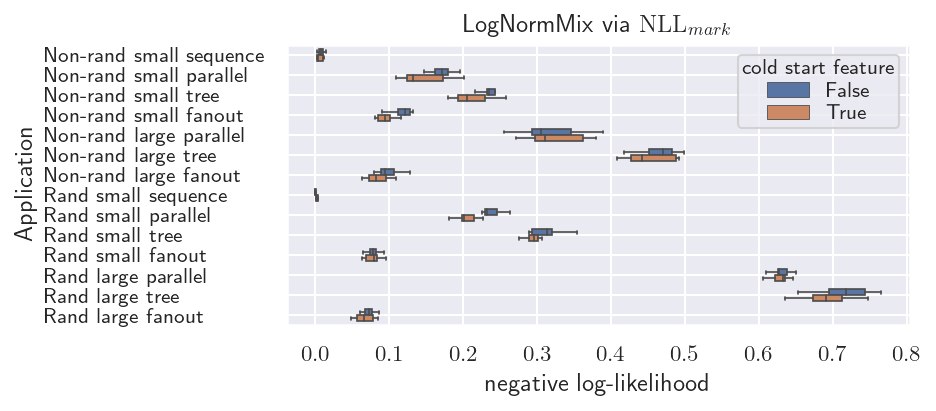

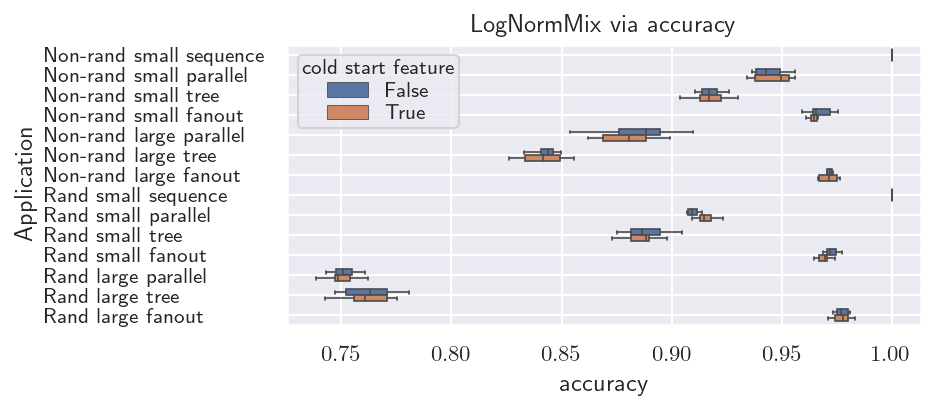

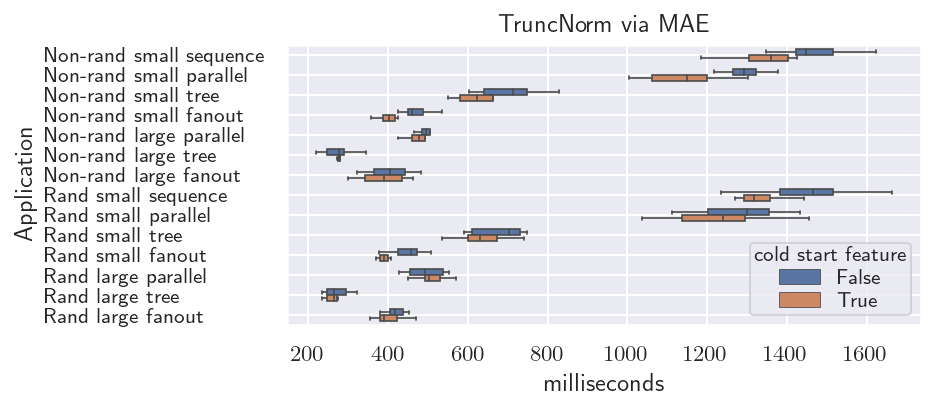

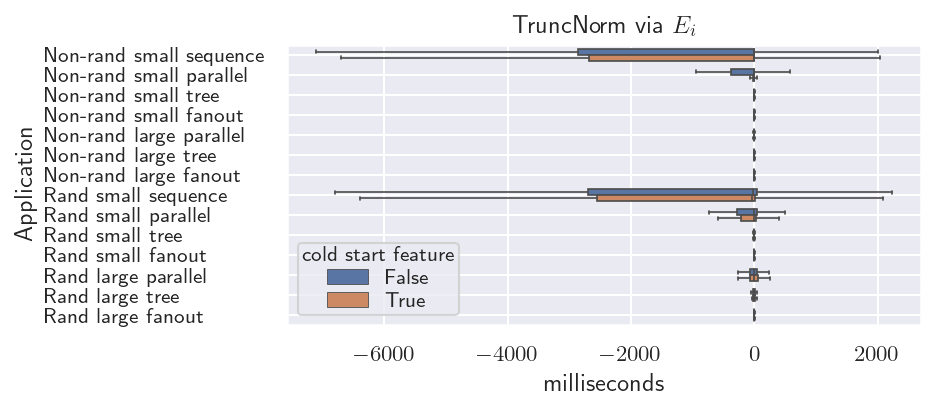

In [6]:
# Low load and high load plots
sns.set(rc={
    "figure.dpi": 150,
    "figure.figsize": (6.4, 2.9),
    "legend.title_fontsize": "small",
    "legend.fontsize": "small",
    "legend.borderpad": 0.2,
    "legend.labelspacing": 0.2,
    "ytick.labelsize": "small",
    "ytick.major.pad": 110,
    "axes.labelsize": "medium",
    "axes.grid": True,
    "text.usetex": True,
})
sns.color_palette("tab10")

apps = ["fanout_small", "parallel_small", "sequence", "tree_small", "fanout_large", "parallel_large", "tree_large"]
#order = apps + list(map(lambda app_name: app_name + "_rand", apps))
order = list(y_label_map.values())
title_prefix, hue, dodge, save_prefix = None, None, None, None
dirs = [(False, "final_low_load_n_1000"), (True, "final_high_load_n_1000")]
safe = False

for cold_starts, results_dir in dirs:
    
    if cold_starts:
        dodge = True
        hue = "cold_starts"
        save_prefix = "highload"
    else:        
        dodge = False
        save_prefix = "lowload"

    fig, ax = plt.subplots()
    obs = observations_from_apps(apps, results_dir, "final_loss_test", cold_starts)
    sns.boxplot(x="value", y="app_name", hue=hue, data=obs, dodge=dodge, order=order, width=0.6, showfliers=False, linewidth=0.8)
    ax.grid(True)
    ax.set_title(r"LogNormMix via $\textnormal{NLL}_{total}$")
    ax.set_ylabel("Application")
    ax.set_xlabel("negative log-likelihood")
    ax.set_yticklabels(ax.get_yticklabels(), ha="left")
    if cold_starts:
        ax.legend(title="cold start feature")
    plt.tight_layout()
    if safe:
        plt.savefig(f"result_plots/{save_prefix}_total_nll.pdf")
       
    fig, ax = plt.subplots()
    obs = observations_from_apps(apps, results_dir, "final_time_nll_test", cold_starts)
    sns.boxplot(x="value", y="app_name", hue=hue, data=obs, dodge=dodge, order=order, width=0.6, showfliers=False, linewidth=0.8)
    ax.grid(True)
    ax.set_title(r"LogNormMix via $\textnormal{NLL}_{time}$")
    ax.set_ylabel("Application")
    ax.set_xlabel("negative log-likelihood")
    ax.set_yticklabels(ax.get_yticklabels(), ha="left")
    if cold_starts:
        ax.legend(title="cold start feature")
    plt.tight_layout()
    if safe:
        plt.savefig(f"result_plots/{save_prefix}_time_nll.pdf")
    
    fig, ax = plt.subplots()
    obs = observations_from_apps(apps, results_dir, "final_mark_nll_test", cold_starts)
    sns.boxplot(x="value", y="app_name", hue=hue, data=obs, dodge=dodge, order=order, width=0.6, showfliers=False, linewidth=0.8)
    ax.grid(True)
    ax.set_title(r"LogNormMix via $\textnormal{NLL}_{mark}$")
    ax.set_ylabel("Application")
    ax.set_xlabel("negative log-likelihood")
    ax.set_yticklabels(ax.get_yticklabels(), ha="left")
    if cold_starts:
        ax.legend(title="cold start feature")
    plt.tight_layout()
    if safe:
        plt.savefig(f"result_plots/{save_prefix}_mark_nll.pdf")

    fig, ax = plt.subplots()
    obs = observations_from_apps(apps, results_dir, "final_acc_test", cold_starts)
    sns.boxplot(x="value", y="app_name", hue=hue, data=obs, dodge=dodge, order=order, width=0.6, showfliers=False, linewidth=0.8)
    ax.grid(True)
    ax.set_title("LogNormMix via accuracy")
    ax.set_ylabel("Application")
    ax.set_xlabel("accuracy")
    ax.set_yticklabels(ax.get_yticklabels(), ha="left")
    if cold_starts:
        ax.legend(title="cold start feature")
    plt.tight_layout()
    if safe:
        plt.savefig(f"result_plots/{save_prefix}_acc.pdf")

    fig, ax = plt.subplots()
    obs = observations_from_apps(apps, results_dir, "final_mae_test", cold_starts)
    sns.boxplot(x="value", y="app_name", hue=hue, data=obs, dodge=dodge, order=order, width=0.6, showfliers=False, linewidth=0.8)
    ax.grid(True)
    ax.set_title("TruncNorm via MAE")
    ax.set_ylabel("Application")
    ax.set_xlabel("milliseconds")
    ax.set_yticklabels(ax.get_yticklabels(), ha="left")
    if cold_starts:
        ax.legend(title="cold start feature")
    plt.tight_layout()
    if safe:
        plt.savefig(f"result_plots/{save_prefix}_mae.pdf")

    fig, ax = plt.subplots()
    obs = observations_from_apps(apps, results_dir, "inter_time_errors", cold_starts)
    sns.boxplot(x="value", y="app_name", hue=hue, data=obs, dodge=dodge, order=order, width=0.6, showfliers=False, linewidth=0.8)
    ax.grid(True)
    ax.set_title(r"TruncNorm via $E_i$")
    ax.set_ylabel("Application")
    ax.set_xlabel("milliseconds")
    ax.set_yticklabels(ax.get_yticklabels(), ha="left")
    if cold_starts:
        ax.legend(title="cold start feature")
    plt.tight_layout()
    if safe:
        plt.savefig(f"result_plots/{save_prefix}_err.pdf")